# CNN

## Preproccesing

In [ ]:
!pip install datasets
# !pip install transformers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from pathlib import Path
from glob import glob
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset, Image
# import transformers
import tensorflow as tf

In [ ]:
train_dataset = load_dataset('cifar10', split="train")
test_dataset = load_dataset('cifar10', split="test")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


In [ ]:
train_dataset.set_format(type = 'tf')
test_dataset.set_format(type = 'tf')

In [ ]:
x_train = train_dataset['img']
y_train = train_dataset['label']

x_test = test_dataset['img']
y_test = test_dataset['label']

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

### Model

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.Rescaling(1/255)
])

In [ ]:
base_model = tf.keras.applications.DenseNet201(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

74836368/74836368 [==============================] - 3s 0us/step


In [ ]:
for i, layer in enumerate(base_model.layers):
  if  layer.name == 'conv5_block1_0_bn':
    print(i)
    break

481


In [ ]:
for layer in base_model.layers[:i]:
  layer.trainable = False
for layer in base_model.layers[i:]:
  layer.trainable = True

In [ ]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
head_model = tf.keras.models.Sequential()
head_model.add(tf.keras.layers.GlobalAveragePooling2D())
head_model.add(tf.keras.layers.Dense(256, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(10  , activation='softmax'))


In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = base_model(x)
outputs = head_model(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])

batch_size = 512
epochs = 10
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6,
                              patience=1,
                              verbose=0, min_lr=1e-7)

### densenet201

In [ ]:
history = model.fit(x_train, y_train_cat,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test_cat),
          callbacks=[reduce_lr])

Epoch 1/10
98/98 [==============================] - 479s 4s/step - loss: 0.6323 - accuracy: 0.7871 - val_loss: 0.3640 - val_accuracy: 0.8738 - lr: 1.0000e-04
Epoch 2/10
98/98 [==============================] - 311s 3s/step - loss: 0.2633 - accuracy: 0.9103 - val_loss: 0.2843 - val_accuracy: 0.9033 - lr: 1.0000e-04
Epoch 3/10
98/98 [==============================] - 311s 3s/step - loss: 0.1653 - accuracy: 0.9453 - val_loss: 0.2518 - val_accuracy: 0.9140 - lr: 1.0000e-04
Epoch 4/10
98/98 [==============================] - 311s 3s/step - loss: 0.1006 - accuracy: 0.9689 - val_loss: 0.2566 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 5/10
98/98 [==============================] - 311s 3s/step - loss: 0.0537 - accuracy: 0.9853 - val_loss: 0.2722 - val_accuracy: 0.9162 - lr: 1.0000e-04
Epoch 6/10
98/98 [==============================] - 310s 3s/step - loss: 0.0275 - accuracy: 0.9936 - val_loss: 0.2760 - val_accuracy: 0.9189 - lr: 6.0000e-05
Epoch 7/10
98/98 [==============================] - 

In [ ]:
history1 = {'loss':[0.6323,0.2633,0.1653,0.1006,0.0537,0.0275,0.0157,0.0110,0.0067,0.0057],
            'accuracy':[0.7871,0.9103,0.9453,0.9689,0.9853,0.9936,0.9972,0.9985,0.9993,0.9994],
            'val_loss':[0.3640,0.2843,0.2518,0.2566,0.2722,0.2760,0.2906,0.3102,0.3034,0.3104],
            'val_accuracy':[0.8739,0.9033,0.9140,0.9167,0.9162,0.9189,0.9205,0.9182,0.9208,0.9189]}

In [ ]:
history2 =  model.fit(x_train, y_train_cat,
          batch_size = batch_size,
           epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test_cat),
          callbacks=[reduce_lr])

Epoch 1/10
98/98 [==============================] - 496s 4s/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.3134 - val_accuracy: 0.9207 - lr: 2.1600e-05
Epoch 2/10
98/98 [==============================] - 358s 4s/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.3166 - val_accuracy: 0.9210 - lr: 2.1600e-05
Epoch 3/10
98/98 [==============================] - 359s 4s/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.3212 - val_accuracy: 0.9208 - lr: 2.1600e-05
Epoch 4/10
98/98 [==============================] - 318s 3s/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0.3239 - val_accuracy: 0.9216 - lr: 1.2960e-05
Epoch 5/10
98/98 [==============================] - 359s 4s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3269 - val_accuracy: 0.9208 - lr: 1.2960e-05
Epoch 6/10
98/98 [==============================] - 359s 4s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.3291 - val_accuracy: 0.9214 - lr: 7.7760e-06
Epoch 7/10
98/98 [==============================] - 

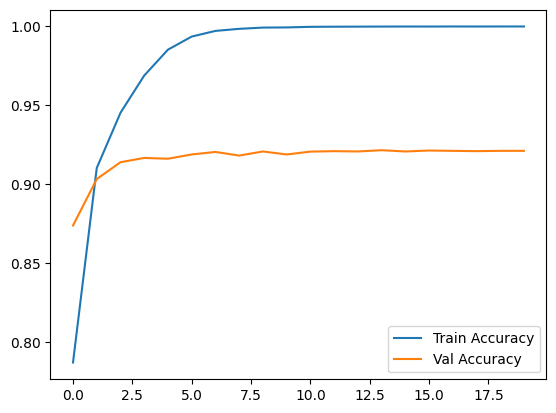

In [ ]:
plt.plot(history1['accuracy'] + history2.history['accuracy'])
plt.plot(history1['val_accuracy'] + history2.history['val_accuracy'])
plt.legend(['Train Accuracy', 'Val Accuracy'])

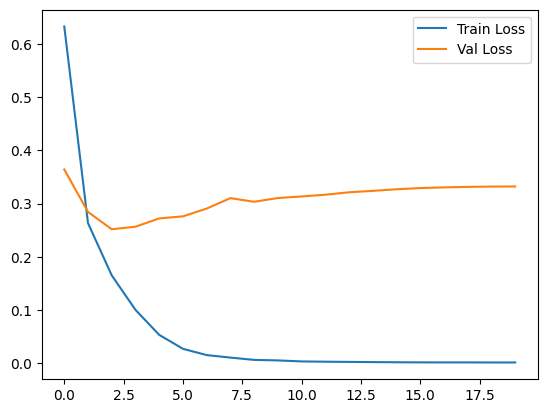

In [ ]:
plt.plot(history1['loss'] + history2.history['loss'])
plt.plot(history1['val_loss'] + history2.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_weights('/content/drive/MyDrive/checkpoints/my_checkpoint')

In [ ]:
model.load_weights('/content/drive/MyDrive/checkpoints/my_checkpoint')

## same implementation with pytorch (memory error)

In [ ]:
from torchvision.transforms import Compose, ToTensor, Resize, RandomHorizontalFlip, Normalize

train_transform = Compose([
    #  Resize((64,64)),
     RandomHorizontalFlip(),
     ToTensor(),
    #  Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])


test_transform = Compose([
    #  Resize((64,64)),
     ToTensor(),
    #  Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

In [ ]:
from torch.utils.data import DataLoader

def collate_fn_train(examples):
    images = []
    labels = []
    for example in examples:
        images.append(train_transform(example["img"]))
        labels.append(example["label"])
        
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return pixel_values, labels

def collate_fn_test(examples):
    images = []
    labels = []
    for example in examples:
        images.append(test_transform(example["img"]))
        labels.append(example["label"])
        
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return pixel_values, labels
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_train, batch_size=512)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_test, batch_size=512)
print(f"The length of train_dataloader per batch is {len(train_dataloader)}")
print(f"The length of test_dataloader per batch is {len(test_dataloader)}")

The length of train_dataloader per batch is 98
The length of test_dataloader per batch is 20


### model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import os
import gc
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [ ]:
import tensorflow as tf

In [ ]:
import transformers

In [ ]:
model = torchvision.models.densenet201(pretrained=True)

for name, layer in model.named_children():
        for n, l in layer.named_modules():
                l.requires_grad_ = False
model.features.denseblock4.requires_grad_ = True
model.classifier=nn.Sequential(
    nn.Linear(in_features=1920,out_features=256),
    nn.Dropout(0.005),
    nn.ELU(),
    nn.Linear(in_features=256,out_features=10),
    # nn.Softmax()
)

model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(),
                           lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 0, factor = 0.6, min_lr=1e-7)

### train funcs

In [ ]:
def train(model,dataloader,loss_fn,optimizer,device):
    model.train()
    train_loss = 0
    epoch_corrects = 0
    total_pics = 0
    for batch, (X,y) in enumerate(dataloader):
      
        gc.collect()
        X = X.to(device)
        y = y.to(device)
        gc.collect()
        y_preds = model.forward(X)
        
        del X
        gc.collect()
        torch.cuda.empty_cache()
        loss = loss_fn(y_preds, y)
        train_loss += loss.item()
        batch_corrects = sum(y == y_preds.argmax(dim = 1))
        epoch_corrects += batch_corrects
        total_pics += len(y)
        optimizer.zero_grad()
        
        gc.collect()
        loss.backward()
        
        gc.collect()
        torch.cuda.empty_cache()
        optimizer.step()
    train_loss = train_loss / len(dataloader)
    epoch_accuracy = epoch_corrects / total_pics
    return train_loss, epoch_accuracy

In [ ]:
def val(model,dataloader,loss_fn,device):
    model.eval()
    epoch_corrects = 0
    val_loss = 0
    total_pics = 0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_logits = model.forward(X)
        
        loss = loss_fn(y_logits, y)
        val_loss += loss.item()
        batch_corrects = sum(y == y_logits.argmax(dim = 1))
        epoch_corrects += batch_corrects
        total_pics += len(y)
        
    val_loss = val_loss / len(dataloader)
    epoch_accuracy = epoch_corrects / total_pics
    return val_loss, epoch_accuracy

In [ ]:
EPOCHS = 20

def train_and_val(model,train_dataloader,val_dataloader,loss_fn,optimizer,
                 epochs,device):
    results = {"train_loss": [],
              "val_loss": [],
               "train_acc": [],
              "val_acc": []}
    for epoch in range(epochs):
        train_loss, train_acc = train(model=model,dataloader=train_dataloader, loss_fn=loss_fn,
             optimizer=optimizer,device=device)
        
        val_loss, val_acc = val(model=model,dataloader=val_dataloader,
           loss_fn=loss_fn,device=device)
        scheduler.step(val_acc)
        print(f"Epoch {epoch+1} of {EPOCHS} \n Train Loss:{train_loss:.3f} || Val Loss: {val_loss:.3f} || Train Accuracy:{train_acc:.3f} || Val Accuracy: {val_acc:.3f} lr = {optimizer.param_groups[0]['lr']}")
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc.cpu().numpy())
        results['val_acc'].append(val_acc.cpu().numpy())
        
        
    return results

### training

In [ ]:
model_results = train_and_val(model=model,train_dataloader=train_dataloader,
                             val_dataloader=test_dataloader,loss_fn=loss_fn,
                             optimizer=optimizer,epochs=EPOCHS,device=device)

Epoch 1 of 20 
 Train Loss:1.153 || Val Loss: 0.630 || Train Accuracy:0.631 || Val Accuracy: 0.783 lr = 0.0001
Epoch 2 of 20 
 Train Loss:0.469 || Val Loss: 0.514 || Train Accuracy:0.839 || Val Accuracy: 0.826 lr = 0.0001
Epoch 3 of 20 
 Train Loss:0.268 || Val Loss: 0.512 || Train Accuracy:0.910 || Val Accuracy: 0.835 lr = 0.0001
Epoch 4 of 20 
 Train Loss:0.148 || Val Loss: 0.551 || Train Accuracy:0.953 || Val Accuracy: 0.837 lr = 0.0001
Epoch 5 of 20 
 Train Loss:0.081 || Val Loss: 0.597 || Train Accuracy:0.976 || Val Accuracy: 0.841 lr = 0.0001
Epoch 6 of 20 
 Train Loss:0.054 || Val Loss: 0.647 || Train Accuracy:0.984 || Val Accuracy: 0.839 lr = 6e-05
Epoch 7 of 20 
 Train Loss:0.027 || Val Loss: 0.640 || Train Accuracy:0.993 || Val Accuracy: 0.847 lr = 6e-05
Epoch 8 of 20 
 Train Loss:0.015 || Val Loss: 0.650 || Train Accuracy:0.996 || Val Accuracy: 0.851 lr = 6e-05
Epoch 9 of 20 
 Train Loss:0.008 || Val Loss: 0.679 || Train Accuracy:0.998 || Val Accuracy: 0.849 lr = 3.6e-05
Epo

### result

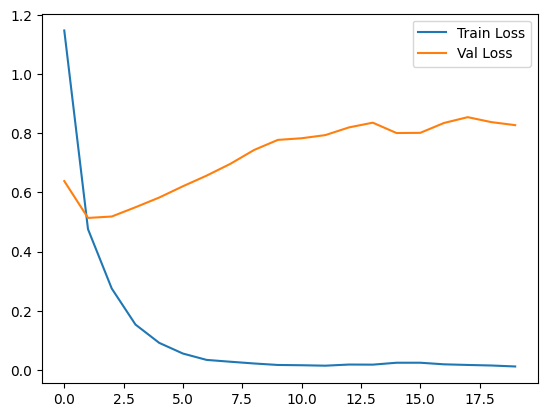

In [ ]:
plt.plot(model_results['train_loss'])
plt.plot(model_results['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

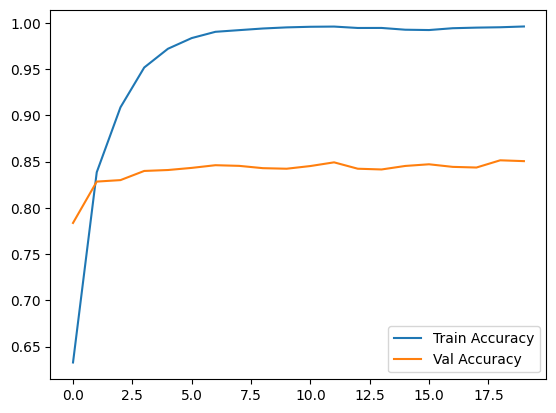

In [ ]:
plt.plot(model_results['train_acc'])
plt.plot(model_results['val_acc'])
plt.legend(['Train Accuracy', 'Val Accuracy'])

# Transformer

## preproccsing

In [ ]:
!pip install datasets
# !pip install transformers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from pathlib import Path
from glob import glob
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset, Image
# import transformers
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
train_dataset = load_dataset('cifar10', split="train")
test_dataset = load_dataset('cifar10', split="test")

In [ ]:
train_dataset.set_format(type = 'tf')
test_dataset.set_format(type = 'tf')

In [ ]:
x_train = train_dataset['img']
y_train = train_dataset['label']

x_test = test_dataset['img']
y_test = test_dataset['label']

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## model

In [ ]:
model_gcs_path = "gs://tfhub-modules/sayakpaul/deit_base_distilled_patch16_224_fe/1/uncompressed"
base_model = tf.keras.models.load_model(model_gcs_path)

In [ ]:
# model_gcs_path = "https://tfhub.dev/sayakpaul/cait_s24_224_fe/1"
# base_model = hub.KerasLayer(model_gcs_path)

In [ ]:
for layer in base_model.layers[:-3]:
  layer.trainable = False
for layer in base_model.layers[-3:]:
  layer.trainable = True

In [ ]:
# base_model.trainable = True

In [ ]:
base_model.summary()

Model: "vi_t_distilled"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection (Sequential)     (None, 196, 768)          590592    
                                                                 
 transformer_block_0 (Functi  [(None, 198, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_1 (Functi  [(None, 198, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_2 (Functi  [(None, 198, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_3 (Functi  [(None, 198, 768),       7087872   
 onal)                        (None, 12, None, None)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.Rescaling(1/255)
])

In [ ]:
head_model = tf.keras.models.Sequential()
head_model.add(tf.keras.layers.Flatten())
head_model.add(tf.keras.layers.Dense(1024, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(10  , activation='softmax'))


In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x, _ = base_model(x)
del _
outputs = head_model(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vi_t_distilled (ViTDistille  ((None, 768),            85800192  
 d)                           {'transformer_block_3_a            
                             tt': (None, 12, None, No            
                             ne),                                
                              'transformer_block_11_a            
                             tt': (None, 12, None, No            
                             ne),                                
                              'transformer_block_5_at            
                             t': (None, 12, None, Non      

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])

batch_size = 128
epochs = 10
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6,
                              patience=1,
                              verbose=0, min_lr=1e-7)

## result

In [ ]:
history = model.fit(x_train, y_train_cat,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test_cat),
          callbacks=[reduce_lr])

Epoch 1/10
391/391 [==============================] - 178s 434ms/step - loss: 0.3373 - accuracy: 0.8848 - val_loss: 0.2007 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 2/10
391/391 [==============================] - 168s 431ms/step - loss: 0.1370 - accuracy: 0.9537 - val_loss: 0.1633 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 3/10
391/391 [==============================] - 168s 431ms/step - loss: 0.0905 - accuracy: 0.9695 - val_loss: 0.1517 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 4/10
391/391 [==============================] - 168s 431ms/step - loss: 0.0658 - accuracy: 0.9777 - val_loss: 0.1560 - val_accuracy: 0.9530 - lr: 0.0010
Epoch 5/10
391/391 [==============================] - 168s 431ms/step - loss: 0.0513 - accuracy: 0.9830 - val_loss: 0.1624 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 6/10
391/391 [==============================] - 168s 431ms/step - loss: 0.0402 - accuracy: 0.9869 - val_loss: 0.1791 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 7/10
391/391 [==========================

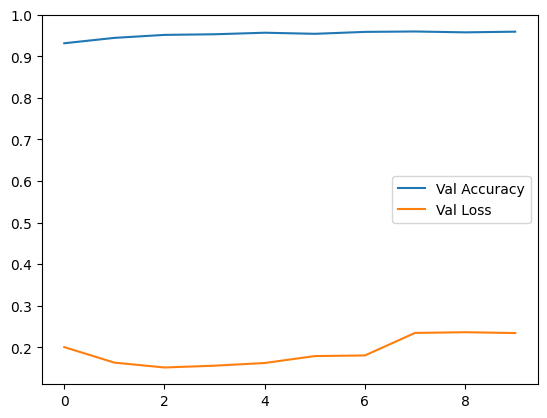

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['Val Accuracy', 'Val Loss'])